## "Normale" und Convolutional Neural Networks

Am Beispiel des [CIFAR-10 Datensatzes](https://www.cs.toronto.edu/~kriz/cifar.html) wollen wir Unterschiede zwischen "normalen" und Convolutional Neural Networks (CNN) untersuchen. 

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

In [25]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    ])
     # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
     # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64
num_workers = 10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


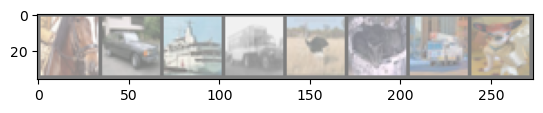

     horse   car     ship    truck   bird    cat     truck   dog    


In [26]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print('     ' + ' '.join(f'{classes[labels[j]]:7s}' for j in range(8)))

In [31]:
import torch.optim as optim
from tqdm.notebook import tqdm

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train(model, epochs=10, criterion=None, optimizer=None, device=None):
    
    print(f"training model with {count_parameters(model)} parameters")
    
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
        
    if optimizer is None:
        optimizer = optim.AdamW(model.parameters(), lr=0.0001)
    
    if device is None:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f"Using {device} for training")
    
    model = model.to(device)
    learn_data = []
    
    with  tqdm(range(epochs)) as iterator:
        for epoch in iterator:  # loop over the dataset multiple times

            correct = 0
            total = 0
            running_loss = 0.0
            count = 0
            for data in trainloader:
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data[0].to(device), data[1].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # print statistics
                running_loss += loss.item()
                count += 1

            train_loss = running_loss/count
            train_accuracy = 100 * correct / total

            correct = 0
            total = 0
            running_loss = 0
            count = 0
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)

                    # calculate outputs by running images through the network
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()
                    count += 1

                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            test_loss = running_loss/count
            test_accuracy = 100 * correct / total

            learn_data.append({ "train_loss": train_loss, "test_loss": test_loss, "train_accuracy": train_accuracy, "test_accuracy": test_accuracy })
            iterator.set_postfix_str(f"train_loss: {train_loss:.2f}, test_loss: {test_loss:.2f}, train_accuracy: {train_accuracy:.2f}%, test_accuracy: {test_accuracy:.2f}%")

    return learn_data


In [32]:
def plot(learn_data):
    
    fig, ax1 = plt.subplots()
    ax1.plot([ data["train_accuracy"] for data in learn_data ], label="train_acc")
    ax1.plot([ data["test_accuracy"] for data in learn_data ], label="test_acc")
    ax1.legend()
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("accuracy")
    ax1.plot()
    
    ax2 = ax1.twinx()
    ax2.plot([ data["train_loss"] for data in learn_data ], ':', label="train_loss")
    ax2.plot([ data["test_loss"] for data in learn_data ], ':', label="test_loss")
    ax2.legend()
    ax2.set_ylabel("loss")
    ax2.plot()

In [44]:
from torchvision import transforms
from torchvision import models

vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
vgg.classifier[-1].out_features = 10
vgg = vgg.cuda()

In [40]:
learn_data = train(vgg, epochs=10)
plot(learn_data)

training model with 138357544 parameters
Using cuda:0 for training


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [41]:
resnet = models.resnext101_32x8d(weights=models.ResNeXt101_32X8D_Weights.IMAGENET1K_V2)
resnet

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-110c445d.pth" to /home/chgaw002/.cache/torch/hub/checkpoints/resnext101_32x8d-110c445d.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [42]:
resnet.fc.out_features = 10
resnet = resnet.cuda()

training model with 88791336 parameters
Using cuda:0 for training


  0%|          | 0/10 [00:00<?, ?it/s]

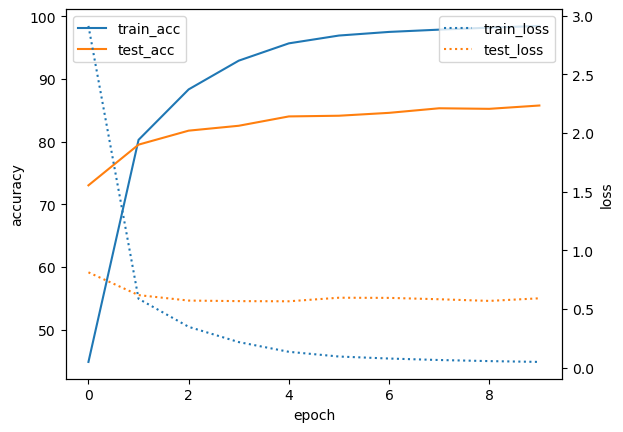

In [43]:
learn_data = train(resnet, epochs=10)
plot(learn_data)